# Gaussian processes

**Gaussian Processes (GPs) are a powerful way to think about functions as distributions. Instead of predicting a single function, a GP places a distribution over functions and allows us to do regression in a Bayesian way.**

- Functions as Random Variables
   - A Gaussian Process is like an extension of the multivariate normal distribution.  
   - Instead of a distribution over vectors, it is a distribution over functions.  

- Defined by Mean and Covariance
   - A GP is written as:  $f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))$ 
   - $\mu(x)$: mean function (often assumed 0).  
   - $ k(x, x') $: covariance (kernel) function, which encodes how similar two points are.  

- Test Points as Random Variables
   - If we pick $N$ test points $\{x_1, \dots, x_N\}$, the function values $[f(x_1), f(x_2), \dots, f(x_N)]$ follow a multivariate Gaussian distribution.  


### Kernels (Covariance Functions)

The kernel $k(x, x')$ is the heart of a GP — it defines the shape of functions we expect.

- RBF / Squared Exponential (smooth functions)  
  $k(x, x') = \sigma^2 \exp\!\left(-\frac{\|x-x'\|^2}{2l^2}\right)$  

- Periodic Kernel (repeating patterns)  
  $k(x, x') = \sigma^2 \exp\!\left(-\frac{2 \sin^2(\pi |x-x'|/p)}{l^2}\right)$  

- Linear Kernel (straight-line trend)  
  $k(x, x') = \sigma_b^2 + \sigma^2(x-c)(x'-c)$

### Stochastic Process

A [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) describes a system that evolves randomly over time (or space).  

- Even if the starting point is known, there are many possible ways the process can unfold.  
- Each "path" or "trajectory" of the process is just **one random sample** from all possibilities.
- Imagine a particle moving randomly in a fluid, bumped around by other molecules.  
- In **1D Brownian motion**, the position $d(t)$ at time $t$ evolves as:

$$
d(t + \Delta t) = d(t) + \Delta d
$$  

where the step size $\Delta d$ is drawn from a normal distribution:

$$
\Delta d \sim \mathcal{N}(0, \Delta t).
$$  

- This means: each small step is random, with mean $0$ and variance proportional to $\Delta t$.
- Brownian motion is just one example of a stochastic process. A Gaussian Process (GP) is a generalization of this idea.  

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.spatial
from scipy.special import erf
from ipywidgets import interact, widgets, IntSlider, FloatSlider
import scipy.stats
import arviz as az
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import pandas as pd
import pymc as pm
from aesara import tensor as at
import pytensor.tensor as pt
import aesara
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

sns.set_style('darkgrid')
np.random.seed(42)

In [13]:
# 1D simulation of the Brownian motion process
def simulate_brownian(total_time=1.0, nb_steps=75, nb_processes=5):
    plt.close('all')
    delta_t = total_time / nb_steps
    mean = 0.0
    stdev = np.sqrt(delta_t)

    distances = np.cumsum(np.random.normal(mean, stdev, (nb_processes, nb_steps)), axis=1)

    t = np.arange(0, total_time, delta_t)
    t = np.hstack([0, t])  # starting point 0
    distances = np.hstack([np.zeros((nb_processes, 1)), distances])  # starting at 0

    plt.figure(figsize=(6,4))
    for i in range(nb_processes):
        plt.plot(t, distances[i,:])
    plt.title(f'Brownian motion')
    plt.xlabel('t (time)')
    plt.ylabel('d (position)')
    plt.xlim([0, total_time])
    plt.tight_layout()
    plt.show()

interact(simulate_brownian,
         total_time=widgets.FloatSlider(description="Time", value=1.0, min=0.5, max=5.0, step=0.5), # duration of the process
         nb_steps=widgets.IntSlider(description="Steps", value=75, min=10, max=200, step=5), # to divide in total time (more steps = more precision)
         nb_processes=widgets.IntSlider(description="Realizations", value=5, min=1, max=20, step=1)) # number of independent realizations

# We are simulating a particle moving randomly in 1D. total_time is how long we watch it move. 
# nb_steps decides how finely we break this time into small intervals, and at each interval the particle moves randomly. 
# nb_processes shows multiple possible paths the particle could take. This demonstrates the stochastic nature of the process.

interactive(children=(FloatSlider(value=1.0, description='Time', max=5.0, min=0.5, step=0.5), IntSlider(value=…

<function __main__.simulate_brownian(total_time=1.0, nb_steps=75, nb_processes=5)>

### Covariance Function

The kernel function needs to be positive-definite in order to be a valid covariance function.
In this, we will model the covariance with the exponentiated quadratic (RBF) kernel:

$$
k(x_a, x_b) = \sigma^2 \exp\Big( - \frac{\lVert x_a - x_b \rVert^2}{2 l^2} \Big)
$$

In [14]:
# rbf kernel
def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1,1) + np.sum(X2**2, 1) - 2*np.dot(X1, X2.T)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

In [15]:
# Covariance matrix and function with fixed color scale
def plot_covariance_matrix_fixed(sigma=1.0, length=1.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Covariance matrix heatmap
    xlim = (-3, 3)
    X = np.expand_dims(np.linspace(*xlim, 25), 1)
    Σ = np.exp(-0.5 * ((X - X.T)/length)**2) * sigma**2  # RBF kernel
    im = ax1.imshow(Σ, cmap=cm.YlGnBu, vmin=0, vmax=1)   # fixed color scale
    plt.colorbar(im, ax=ax1, fraction=0.045, pad=0.05)
    ax1.set_title(f'Covariance matrix')
    ax1.set_xlabel('x')
    ax1.set_ylabel('x')
    
    # Covariance with X=0
    xlim = (-4, 4)
    X = np.expand_dims(np.linspace(*xlim, 50), 1)
    zero = np.array([[0]])
    Σ0 = sigma**2 * np.exp(-0.5 * ((X - zero)/length)**2)
    ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
    ax2.set_title('Covariance with x=0')
    ax2.set_xlabel('x')
    ax2.set_ylabel('covariance')
    ax2.set_ylim([0, 1])
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

interact(plot_covariance_matrix_fixed,
         sigma=widgets.FloatSlider(description="Variance", value=1.0, min=0.1, max=1, step=0.1),
         length=widgets.FloatSlider(description="Length", value=1.0, min=0.1, max=1, step=0.1))
# length = wider band = more correlation
# sigma = higher peak = higher variance

interactive(children=(FloatSlider(value=1.0, description='Variance', max=1.0, min=0.1), FloatSlider(value=1.0,…

<function __main__.plot_covariance_matrix_fixed(sigma=1.0, length=1.0)>

### Sampling from the Prior

In practice, we cannot evaluate a Gaussian process (GP) at infinitely many points in its domain. Instead, we sample the function at a finite set of input points $X$, giving us function values: $\mathbf{y} = f(X)$

Sampling Process : 

1. Choose $n$ input points $X$.
2. Compute the covariance matrix $K = k(X, X)$ using the chosen kernel (e.g., RBF).
3. Draw samples from the multivariate Gaussian $\mathcal{N}(0, K)$ to get different function realizations.

No training points yet, so the functions can take any shape allowed by the kernel.

In [16]:
# Sample from the Gaussian process distribution
def interactive_gp_confidence(sigma=1.0, n_functions=50, n_points=41, n_std=1.0):
    
    X = np.expand_dims(np.linspace(-4, 4, n_points), 1) #input
    
    sqdist = scipy.spatial.distance.cdist(X, X, 'sqeuclidean')
    K = np.exp(-0.5 * sqdist / sigma**2) # RBF kernel
    
    ys = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K, size=n_functions) #output
    
    # pointwise mean and std
    mean = np.mean(ys, axis=0)
    std = np.std(ys, axis=0)
    
    # Proportion of points within ±n_std*std
    conf_percent = erf(n_std / np.sqrt(2)) * 100
    
    plt.figure(figsize=(7,4))
    plt.fill_between(X[:,0], mean - n_std*std, mean + n_std*std, color='lightblue', alpha=0.5,
                     label=f'±{n_std:.1f}σ (~{conf_percent:.1f}% interval)')
    for i in range(min(5, n_functions)):  # plot only first 5 functions for clarity
        plt.plot(X, ys[i], marker='o', alpha=0.7)
    
    plt.xlabel('x')
    plt.ylabel('y = f(x)')
    plt.title(f'{n_functions} GP prior samples (σ={sigma:.2f})')
    plt.legend()
    plt.show()
    
interact(interactive_gp_confidence,
         sigma=widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Length'),
         n_functions=widgets.IntSlider(value=3, min=1, max=5, step=1, description='Functions'), # number of sampled functions
         n_points=widgets.IntSlider(value=41, min=5, max=100, step=1, description='Points'), # number of points (Resolution)
         n_std=widgets.FloatSlider(value=1.0, min=0.5, max=3.0, step=0.1, description='Confidence'))

# more length = smoothness
# more points = higher resolution (For Visual only, actual smoothness is from length scale)


interactive(children=(FloatSlider(value=1.0, description='Length', max=3.0, min=0.1), IntSlider(value=3, descr…

<function __main__.interactive_gp_confidence(sigma=1.0, n_functions=50, n_points=41, n_std=1.0)>

### 2D marginal distribution

- The covariance between the two points, k(x1, x2), determines how the two function values y1 and y2 are related.
- If the points are close together in x, the RBF kernel ensures that k(x1, x2) is close to 1 → strongly correlated. In the figure, the points lie roughly along a diagonal line (y1 ≈ y2).
- If the points are far apart, k(x1, x2) is small → almost independent. In the figure, the points are scattered more uniformly with no strong correlation.

In [17]:
# 2D marginal distribution

# GP parameters
sigma = 1.8
n_points = 41
X = np.linspace(-4, 4, n_points).reshape(-1,1)

# RBF kernel
sqdist = scipy.spatial.distance.cdist(X,X,'sqeuclidean')
K = np.exp(-0.5*sqdist/sigma**2)

# Sample functions from GP prior (many functions) here 200
ys_all = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K, size=200)

def plot_2D_marginal(x1_idx, x2_idx, n_samples):
    plt.figure(figsize=(5,5))
        
    mu = [0,0]
    cov = np.array([[K[x1_idx,x1_idx], K[x1_idx,x2_idx]],
                    [K[x2_idx,x1_idx], K[x2_idx,x2_idx]]])
    
    # Add tiny jitter to ensure positive definiteness
    cov += 1e-8 * np.eye(2)

    y1, y2 = np.meshgrid(np.linspace(-3,3,50), np.linspace(-3,3,50))
    pos = np.dstack((y1,y2))
    rv = scipy.stats.multivariate_normal(mu, cov)
    plt.contourf(y1, y2, rv.pdf(pos), cmap='magma_r')

    y_samples = ys_all[:n_samples, [x1_idx, x2_idx]]
    plt.scatter(y_samples[:,0], y_samples[:,1], c='cyan', edgecolor='k', label=f'{n_samples} samples')

    plt.xlabel(f"y1 = f(x={X[x1_idx,0]:.2f})")
    plt.ylabel(f"y2 = f(x={X[x2_idx,0]:.2f})")
    plt.title(f"2D marginal (cov={cov[0][1]:.2f})")
    plt.axis('equal')
    plt.legend()
    plt.show()


interact(plot_2D_marginal,
         x1_idx=IntSlider(min=0, max=n_points-1, step=1, value=0, description='x1 index'),
         x2_idx=IntSlider(min=0, max=n_points-1, step=1, value=20, description='x2 index'),
         n_samples=IntSlider(min=1, max=200, step=1, value=5, description='# samples'))

interactive(children=(IntSlider(value=0, description='x1 index', max=40), IntSlider(value=20, description='x2 …

<function __main__.plot_2D_marginal(x1_idx, x2_idx, n_samples)>

### Gaussian Processes for Regression

**Predictions from the Posterior**

Suppose we have:  
- $n_1$ observed data points $(X_1, \mathbf{y}_1)$  
- $n_2$ new input points $X_2$ where we want predictions $\mathbf{y}_2 = f(X_2)$  

Both $\mathbf{y}_1$ and $\mathbf{y}_2$ come from the **same multivariate Gaussian** distribution. Hence we can write:

$$
\left[\begin{array}{c} 
\mathbf{y}_{1} \\ 
\mathbf{y}_{2} 
\end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} 
\mu_{1} \\ 
\mu_{2} 
\end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right)
$$

Where:  

$$\begin{split}
\mu_{1} & = m(X_1) \quad (n_1 \times 1) \\ 
\mu_{2} & = m(X_2) \quad (n_2 \times 1) \\
\Sigma_{11} & = k(X_1,X_1) \quad (n_1 \times n_1) \\
\Sigma_{22} & = k(X_2,X_2) \quad (n_2 \times n_2) \\
\Sigma_{12} & = k(X_1,X_2) = k_{21}^\top \quad (n_1 \times n_2)
\end{split}$$

$\mathbf{y}_1$: known outputs (training data)

$\mathbf{y}_2$: unknown outputs (test points we want to predict)

$\Sigma_{11}$: covariance among training points

$\Sigma_{22}$: covariance among test points

$\Sigma_{12}, \Sigma_{21}$: covariance between training and test points (this is the “bridge” that lets data influence predictions)

- $\Sigma_{11}$ depends on the observed inputs, while $\Sigma_{22}$ depends on the new inputs.

**Conditional Distribution (Posterior)**

- Given we’ve already seen $\mathbf{y}_1$, what can we say about $\mathbf{y}_2$?
- Using the conditional distribution of a multivariate Gaussian, the posterior is:

$$\begin{split}
p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
          & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \quad (\text{if mean prior } \mu = 0 ) \\
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12}
\end{split}$$


In [18]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

The code below calculates the posterior distribution based on 8 observations from a sine function. The results are plotted below. The top figure shows the distribution where the red line is the posterior mean, the shaded area is the 95% prediction interval, the black dots are the observations $(X_1,\mathbf{y}_1)$.
The prediction interval is computed from the standard deviation $\sigma_{2|1}$, which is the square root of the diagonal of the covariance matrix. The bottom figure shows 5 realizations (sampled functions) from this distribution.  

Note that the distribution is quite confident of the points predicted around the observations $(X_1,\mathbf{y}_1)$, and that the prediction interval gets larger the further away it is from these points.

In [19]:
# True function
f_sin = lambda x: (np.sin(x)).flatten()
domain = (-6, 6)

def interactive_GP(n1=8, n2=75, ny=5):
    # Sample observations (X1, y1)
    X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
    y1 = f_sin(X1)

    # Test points for posterior
    X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

    # Compute posterior
    μ2, Σ2 = GP(X1, y1, X2, rbf_kernel)
    σ2 = np.sqrt(np.diag(Σ2))

    # Sample functions from posterior
    y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

    # Plot posterior mean and confidence interval
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,6))

    ax1.plot(X2, f_sin(X2), 'b--', label='True function $sin(x)$')
    ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', alpha=0.2, label='2σ confidence interval')
    ax1.plot(X2, μ2, 'r-', lw=2, label='Posterior mean')
    ax1.scatter(X1, y1, c='k', label='Observations')
    ax1.set_title(f'GP posterior with {n1} observations')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.legend()
    ax1.set_xlim(domain)
    ax1.set_ylim([-3,3])

    for i in range(ny):
        ax2.plot(X2, y2[i], lw=1)
    ax2.set_title(f'{ny} sample functions from posterior')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_xlim(domain)
    ax2.set_ylim([-3,3])

    plt.tight_layout()
    plt.show()

interact(interactive_GP,
         n1=IntSlider(min=1, max=15, step=1, value=8, description='Observations'),
         n2=IntSlider(min=20, max=150, step=5, value=75, description='Test points'),
         ny=IntSlider(min=1, max=20, step=1, value=5, description='Samples'));
# Few points → GP has little info → wide uncertainty (red band big)
# More points → GP learns sine shape better → uncertainty shrinks
# n2 small → coarse approximation of the function.
# n2 large → smoother, more detailed posterior curve.

interactive(children=(IntSlider(value=8, description='Observations', max=15, min=1), IntSlider(value=75, descr…

### Noisy observations

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can notice this in the plot above because the posterior variance becomes zero at the observations $(X_1,\mathbf{y}_1)$.
We can make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as Gaussian noise with variance $\sigma_\epsilon^2$.

This noise can be modelled by adding it to the covariance kernel of our observations:

$$
\Sigma_{11} = k(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independently distributed). The Gaussian process posterior with noisy observations is implemented in the `GP_noise` method below.

In [22]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(X1.shape[0]))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

The code below calculates the posterior distribution of the previous 8 samples with added noise. Note in the plots that the variance $\sigma_{2|1}^2$ at the observations is no longer 0, and that the functions sampled don't necessarily have to go through these observational points anymore.

In [23]:
f_sin = lambda x: (np.sin(x)).flatten() # True function
domain = (-6, 6)

def interactive_GP_noise(n1=8, n2=75, ny=5, σ_noise=0.5):
    # sample noisy observations
    X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
    y1 = f_sin(X1) + σ_noise * np.random.randn(n1)

    # Test points
    X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

    # Compute posterior mean and covariance
    μ2, Σ2 = GP_noise(X1, y1, X2, rbf_kernel, σ_noise)
    σ2 = np.sqrt(np.diag(Σ2))

    # posterior samples
    y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,6))

    ax1.plot(X2, f_sin(X2), 'b--', label='True $sin(x)$')
    ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', alpha=0.2,
                     label='95% interval (2σ)')
    ax1.plot(X2, μ2, 'r-', lw=2, label='Posterior mean')
    ax1.scatter(X1, y1, c='k', label='Noisy observations')
    ax1.set_xlim(domain); ax1.set_ylim([-3,3])
    ax1.set_title(f'Posterior with noisy data (σ_noise={σ_noise:.2f})')
    ax1.legend()

    for i in range(ny):
        ax2.plot(X2, y2[i], lw=1)
    ax2.set_xlim(domain); ax2.set_ylim([-3,3])
    ax2.set_title(f'{ny} posterior samples')

    plt.tight_layout()
    plt.show()

interact(interactive_GP_noise,
         n1=IntSlider(value=8, min=1, max=15, step=1, description='Observations'),
         n2=IntSlider(value=75, min=20, max=150, step=5, description='Test points'),
         ny=IntSlider(value=5, min=1, max=20, step=1, description='Samples'),
         σ_noise=FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description='Noise'));


interactive(children=(IntSlider(value=8, description='Observations', max=15, min=1), IntSlider(value=75, descr…

# Spatial Gaussian Processes

A Gaussian Process (GP) is a distribution over functions, fully specified by a mean function and a covariance (kernel) function.  
So far, we have mostly considered one-dimensional input domains (e.g., functions of $x \in \mathbb{R}$).  

However, in many real-world problems, the input is spatial (e.g., geographical coordinates, 2D or 3D locations).  
In this case, we use Spatial Gaussian Processes (SGPs).

---

**What makes a Gaussian Process spatial?**

- Input domain:
  - Normal GP: usually $x \in \mathbb{R}$ (1D time series, single-variable input).  
  - Spatial GP: input is multi-dimensional (e.g., location in $\mathbb{R}^2$ for 2D maps, or $\mathbb{R}^3$ for volumetric space).

- Covariance structure:
  - Normal GP: covariance depends on distance in 1D (e.g., how close two time points are).  
  - Spatial GP: covariance depends on spatial distance between two locations.  
    - Example: $k(x, x') = \sigma^2 \exp\!\left(-\frac{\|x - x'\|^2}{2\ell^2}\right)$  
      where $\|x - x'\|$ is the **Euclidean distance** in space.  

- **Interpretation:**  
  - Normal GP: models uncertainty about functions over a line (like regression curves).  
  - Spatial GP: models spatially correlated data (e.g., temperature across a region, pollution levels in a city).  


**Applications**
- Climate and weather prediction (temperature maps, rainfall).  
- Geostatistics (kriging in mining or agriculture).  
- Environmental modeling (air quality, water contamination).  
- Spatial epidemiology (disease spread across regions).  


**Key Difference**
- A normal GP works with *any kind of input features* (could be time, age, etc.).  
- A spatial GP is specialized for spatial data, where nearby locations are more correlated than distant ones.  

### Radon Dataset

- We are using the Radon dataset, which is a well-known dataset in Bayesian modeling.  
- It contains measurements of indoor radon levels across different counties in the United States.  
- Radon is a naturally occurring radioactive gas that can accumulate in houses and is a known health risk.  
- The dataset includes:
  - `county` → the county name where measurements were taken  
  - `fips` → Federal Information Processing Standard code (unique county ID)  
  - `radon` → measured radon levels  
  - Other metadata like floor level of measurement  

Here we restrict our analysis to **Minnesota**, a state with a large number of radon measurements.  


**Data Processing**
- Load dataset
- Loads radon measurements and county identifiers
- convert fips into a string with "US" prefix for later matching with shapefiles
- Factorize each county an integer index and keep the list of unique counties
- Load shapefiles
    - We use Cartopy to load Natural Earth shapefiles.
    - First we get the outline of Minnesota from admin_1_states_provinces
    - Then we load counties (admin_2_counties) and separate them into Counties inside Minnesota with measurements and without counties and Neighboring counties (just outside MN but geographically close).
- Geographic centroids
    - Each county is represented by its centroid coordinates (longitude, latitude).
    - This allows us to build a spatial covariance kernel: nearby counties → more correlated radon levels.

In [25]:
df = pd.read_csv(pm.get_data("radon.csv"), index_col=0, dtype={"fips": int})
df["fips"] = "US" + df["fips"].astype("string")
county_idx, counties = df.county.factorize(sort=True)
unique_fips = df.fips.unique()


In [26]:
# Get the state of Minnesota shapefile
reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_1_states_provinces"
    )
)
minnesota = [
    s
    for s in reader.records()
    if s.attributes["admin"] == "United States of America"
    and s.attributes["name"] == "Minnesota"
][0]


In [27]:
# Get Minnesota counties and neighboring counties shape files
reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_2_counties"
    )
)
minnesota_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(minnesota.geometry)
    and county.geometry.difference(minnesota.geometry).area / county.geometry.area
    < 0.01
]
minnesota_neighbor_counties = [
    county
    for county in reader.records()
    if county.geometry.intersects(minnesota.geometry)
    and county.geometry.difference(minnesota.geometry).area / county.geometry.area > 0.5
]
counties_with_measurements = [
    c for c in minnesota_counties if c.attributes["FIPS"] in unique_fips
]
counties_without_measurements = [
    c for c in minnesota_counties if c.attributes["FIPS"] not in unique_fips
]
len(counties_with_measurements), len(counties_without_measurements), len(
    minnesota_neighbor_counties
)

(85, 2, 37)

In [28]:
# Get a mapping from county names to latitude/longitude
# and another mapping from county names to shapefile records for plotting
county_fips = {counties[idx]: df.fips.iloc[i] for i, idx in enumerate(county_idx)}
fips_to_records = {
    record.attributes["FIPS"]: record for record in counties_with_measurements
}
county_to_records = {c: fips_to_records[county_fips[c]] for c in counties}
county_lonlat = {
    c: np.array(
        [
            county_to_records[c].geometry.centroid.x,
            county_to_records[c].geometry.centroid.y,
        ]
    )
    for c in counties
}
cond_counties = [
    c.attributes["NAME"].upper() for c in counties_without_measurements
] + [
    f"{c.attributes['NAME']} - {c.attributes['REGION']}".upper()
    for c in minnesota_neighbor_counties
]
county_to_records.update(
    {
        name: record
        for name, record in zip(
            cond_counties, counties_without_measurements + minnesota_neighbor_counties
        )
    }
)
cond_county_lonlat = {
    c: np.array(
        [
            county_to_records[c].attributes["longitude"],
            county_to_records[c].attributes["latitude"],
        ]
    )
    for c in cond_counties
}

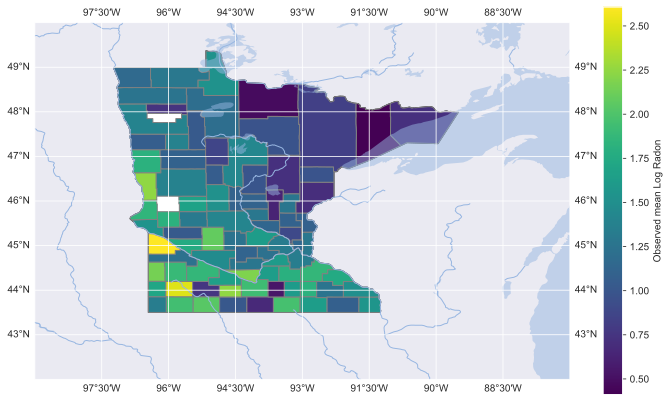

In [29]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot Minnesota state
ax.add_feature(cfeature.ShapelyFeature([minnesota.geometry], ccrs.PlateCarree()),
               edgecolor="k", facecolor="w")

# Color scaling
expected_radon = df.groupby("county")["log_radon"].mean()
vmin = expected_radon.min()
vmax = expected_radon.max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("viridis")

# Plot counties
for county in counties:
    county_record = county_to_records[county]
    if county not in expected_radon.index:
        continue  # Skip counties without measurements
    val = expected_radon[county]
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], ccrs.PlateCarree()),
        edgecolor="gray",
        facecolor=cmap(norm(val)),
    )

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Observed mean Log Radon")

# Add lakes, rivers
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.show()


### Custom PyMC covariance kernel on a sphere

- In spatial Gaussian processes, we often deal with data on the Earth’s surface (latitude-longitude coordinates). Using Euclidean distance directly can be inaccurate because the Earth is curved. To handle this, we define a custom covariance kernel using the chordal distance between points on the sphere.

- Matern32Chordal Class 
    - Inherits from pm.gp.cov.Stationary to define a stationary kernel.
    - Uses Matern 3/2 kernel with chordal distance on a sphere
    - input_dims must be 2 (longitude and latitude).
    - r is the radius of the sphere (default Earth radius = 6378.137 km).

- lonlat2xyz Method
    - Converts longitude/latitude coordinates to 3D Cartesian coordinates on a sphere.
    - This allows distance computations using chordal distance, which is the straight-line distance through the sphere.

- Full Method
    - Computes the full Matern 3/2 covariance matrix based on the chordal distances.
    - Formula for Matern 3/2 kernel:  
    $k(r) = \left(1 + \sqrt{3}\, r\right) \exp\left(-\sqrt{3}\, r\right)$
    - Returns the covariance matrix to be used in the Gaussian process.

**Why Matern Kernel?**

The Matern kernel is widely used in spatial statistics because it is flexible and realistic for geospatial data:
It Can model rough or smooth spatial fields.
Allows explicit control over smoothness with a parameter ν.

Intuition:
- Some kernels (like the RBF) assume infinitely smooth functions.
- Real-world spatial effects (like radon variation across counties) are usually not infinitely smooth; Matern can model moderate roughness.

- The “3/2” refers to the smoothness parameter ν=3/2 in the Matern kernel

In [31]:
class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = lonlat * (np.pi / 180.0)  # convert degrees to radians
        return self.r * pt.stack(
            [
                pt.cos(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X_xyz = self.lonlat2xyz(X)
        Xs_xyz = self.lonlat2xyz(Xs)
        X_xyz = X_xyz[:, None, :]
        Xs_xyz = Xs_xyz[None, :, :]
        return pt.sqrt(pt.sum(((X_xyz - Xs_xyz) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + pt.sqrt(3.0) * r) * pt.exp(-pt.sqrt(3.0) * r)


In [32]:
# del m

**Modeling**

- We are modeling radon levels across Minnesota using a spatial Gaussian Process.
- Each county has longitude and latitude as input features for the GP.
- Coordinates are stored for counties, households, and features for easy indexing.
- Each household is linked to its county index.
- State-level variables:
    - state_mu: overall mean radon level in the state.
    - state_scale: variability of county effects around the state mean.
- Latent GP:
    - Uses Matern 3/2 kernel on a sphere (chordal distance).
    - ls controls how quickly correlations decay with distance.
    - Produces county_eps, the latent county deviation.
- County-level mean: county_mu = state_mu + state_scale * county_eps
- Household-level mean: each household inherits its county’s mean.
- Observation model:
    - Observed log-radon ~ Normal(household mean, measurement error).
    - Measurement error accounts for noise in observations.

In [33]:
X = np.array(list(county_lonlat.values()))
with pm.Model(coords={"county": counties, "household": df.index, "feature": ["longitude", "latitude"]}) as m:
    _county_idx = pm.Data("county_idx", county_idx, dims="household")
    _X = pm.Data("county_X", X, dims=("county", "feature"))

    # State-level variables
    state_mu = pm.Normal("state_mu", 0, 3)
    state_scale = pm.HalfNormal("state_scale", 0.7)
    
    # GP latent
    ls = pm.Gamma("ls", mu=200, sigma=50)
    latent = pm.gp.Latent(cov_func=Matern32Chordal(2, ls))
    county_eps = latent.prior("county_eps", _X, dims="county", jitter=1e-7)
    
    # County-level effect
    county_mu = pm.Deterministic("county_mu", state_mu + state_scale * county_eps, dims="county")
    
    # Household-level mean using PyMC tensor indexing
    household_mu = county_mu[_county_idx]

    measurement_error = pm.HalfNormal("measurement_error", 0.5)
    observed = pm.Normal(
        "log_radon",
        mu=household_mu,
        sigma=measurement_error,
        observed=df.log_radon.values,
        dims="household"
    )



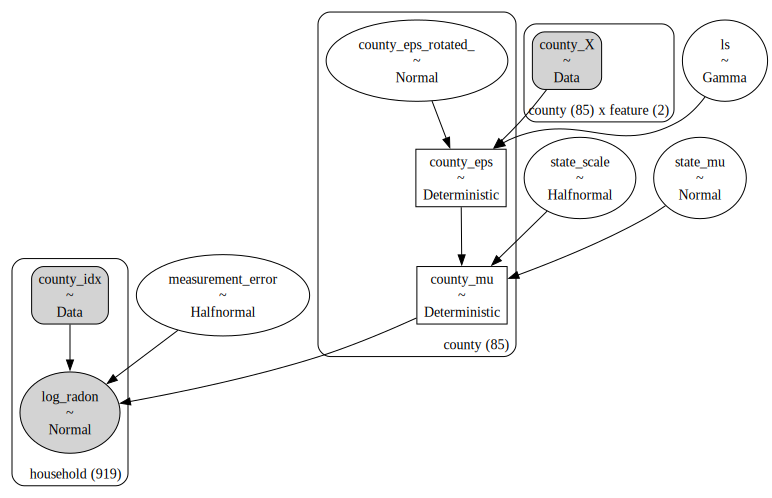

In [34]:
# visual graph of the probabilistic model
pm.model_to_graphviz(m)

### Bayesian Inference in Spatial Gaussian Processes

1. Context

- We  have built a probabilistic model for radon measurements across Minnesota counties. The model includes:
    - Household-level measurements (log_radon)
    - County-level latent effects (county_eps) modeled with a spatial Gaussian process (Matern32Chordal)
    - State-level mean and scale (state_mu, state_scale)
    - Observation noise (measurement_error)
- The goal is to understand how radon levels vary spatially across counties and quantify uncertainty.

2. What pm.sample Does

- The pm.sample function performs Bayesian inference using Markov Chain Monte Carlo (MCMC):
    - Posterior sampling: It generates samples from the posterior distribution of all unknown parameters in the model, given the observed data (df.log_radon.values).
- Unknown parameters include:
    -county_eps: latent deviations for each county (spatial effects)
    - county_mu: county-level mean log-radon (state mean + county deviation)
    - Hyperparameters such as ls (length scale of the GP) and state_scale
- MCMC chains: Multiple chains (here 4) are run to ensure robust exploration of the posterior.
- Tuning/adaptation: The sampler adapts step sizes for efficient sampling.

3. Visualizing Posterior Samples

- Trace plots show the sampled values for each parameter over iterations.
- Purpose:
    - Check convergence (chains mix well and stabilize)
    - Visualize uncertainty (spread of the posterior)
- Posterior interpretation: Each sample represents a plausible state of the world consistent with the data and prior assumptions.

4. What We Achieve

- We can Estimate county-level radon effects, accounting for spatial correlations.
- Quantify uncertainty in these estimates.
- Understand the spatial pattern of radon levels in Minnesota.

In [ ]:
# small test sampling
with m:
    idata = pm.sample(
        draws=5,                    # Number of posterior samples to draw per chain
        # tune=5,                   # Number of tuning (warm-up) steps before sampling (commented out here)
        cores=2,                     # Number of CPU cores to use in parallel for sampling
        init="jitter+adapt_diag_grad",  # Initialization method for the sampler (helps with convergence)
        random_seed=42,              # Seed for reproducibility
        chains=4,                    # Number of independent MCMC chains to run
        target_accept=0.9            # Target acceptance probability for the NUTS sampler (higher => smaller step size)
    )


In [ ]:
# if the previous code takes too much time, reusing the ran results

# idata = az.from_netcdf("gp_results.nc")
# print(idata)

**Real Inference**

A real inference run would typically have:
- draws in the thousands (e.g., 1000–5000 or more per chain).
- A sufficient number of tune steps (warm-up) for adaptation (often 500–2000).
- Enough chains (commonly 4) to assess convergence.

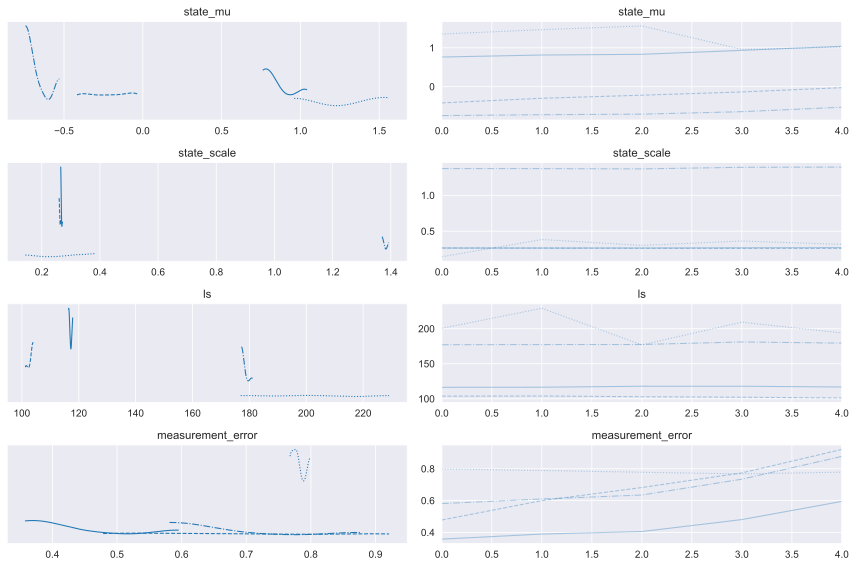

In [37]:
axs = az.plot_trace(idata, var_names=["~county_mu", "~county_eps"], filter_vars="like")
axs[0,0].figure.tight_layout()

## Posterior Predictive Inference

**What We Did?**
- We built a hierarchical Bayesian model with: State-level mean (state_mu), County-level GP latent effects (county_eps) and Household-level mean (household_mu)

**What Are We Doing?**
- Using PyMC’s sample, we infer the posterior distribution of all unknowns given the observed radon measurements.
- This is posterior inference: estimating the distribution of latent variables (county_eps, state_mu, etc.) given data.

In [38]:
cond_X = np.array(list(cond_county_lonlat.values()))
with m:
    m.add_coords({"cond_county": cond_counties})
    _cond_X = pm.Data("cond_X", cond_X, dims=["cond_county", "feature"])
    cond_county_eps = latent.conditional(
        "cond_county_eps", _cond_X, jitter=1e-3, dims="cond_county"
    )
    cond_mu = pm.Deterministic(
        "cond_county_mu", state_mu + state_scale * cond_county_eps, dims="cond_county"
    )
    observed = pm.Normal(
        "cond_log_radon", mu=cond_mu, sigma=measurement_error, dims=["cond_county"],
    )

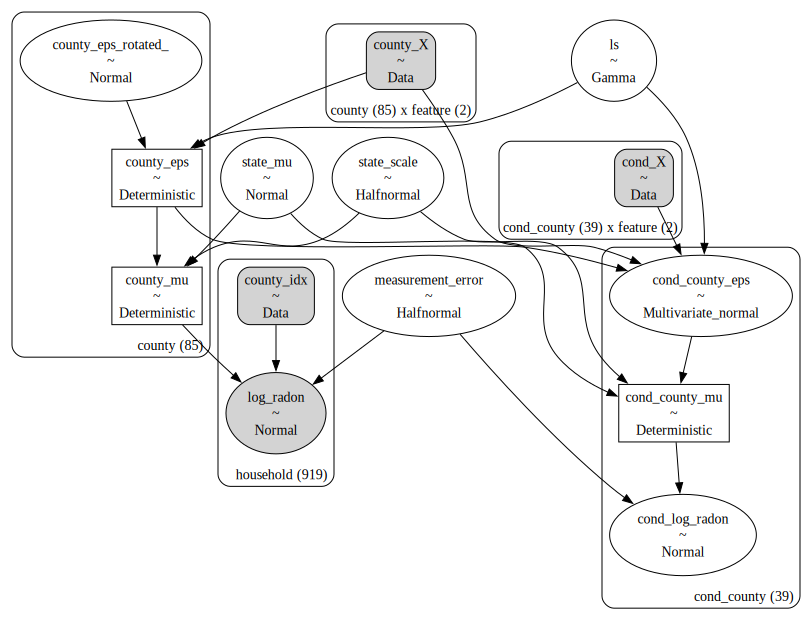

In [39]:
pm.model_to_graphviz(m)

- The new graph represents the predicted radon levels for counties where no measurements were taken.
- Unlike the previous graph (which visualized the posterior over observed counties), this one visualizes posterior predictive distributions for unobserved locations.

### Posterior Predictive Distribution

- Before: We were sampling posterior predictive functions for the radon measurements at the observed counties, showing uncertainty and possible realizations.
- Now: We are doing posterior predictive inference for unobserved counties, i.e., making predictions at new spatial locations using the GP posterior.

**Why Log Radon?**
- Radon levels are strictly positive and often right-skewed
- Taking the logarithm of radon levels makes the distribution more symmetric, closer to Gaussian and stabilizes the variance across counties.
- Helps the GP model make better predictions, because GPs assume roughly Gaussian-distributed outputs.

**Objective**

- To predict log radon levels in counties without direct measurements.
- To visualize the expected values and uncertainties for all counties, both observed and unobserved.

**Why We Do This**

- Some counties do not have radon measurements, but we still want an estimate.
- Spatial Gaussian processes allow us to infer values at unobserved locations by using correlations with nearby counties.
- The posterior predictive distribution provides both the expected value and uncertainty for these predictions.

**What We Use**

- **Posterior distribution** of the latent county-level effects (`county_mu`) obtained from the observed data.
- **Conditional distribution** for unobserved counties, calculated using the spatial GP latent function (`latent.conditional`).
- **Observed data** from counties with measurements to inform predictions.

**How It Works**

1. We take the posterior samples of `county_mu` from the inferred model (`idata`).
2. Using the GP, we compute the **conditional latent values** for counties without measurements.
3. We calculate the expected value (mean) of these posterior predictive samples.
4. We visualize the predicted log radon levels alongside the observed counties on a map:
   - Counties with measurements are colored based on their observed posterior mean.
   - Counties without measurements are colored based on the predicted posterior mean, showing our model’s best estimate.
5. The color map reflects the spatial variation of radon levels across the region, combining observed data and GP-informed predictions.

In [44]:
with m:
    pp = pm.sample_posterior_predictive(
        idata, var_names=["cond_county_mu", "cond_log_radon"], random_seed=42
    )

Sampling: [cond_county_eps, cond_log_radon]


Output()

C:\Users\chait\AppData\Local\Temp\ipykernel_20720\1651437421.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


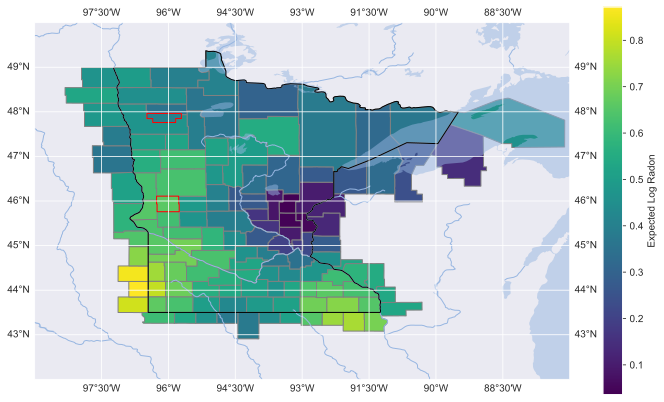

In [ ]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

expected_radon = idata.posterior.county_mu.mean(["chain", "draw"])
pp_expected_radon = pp.posterior_predictive.cond_county_mu.mean(["chain", "draw"]
                                                                )
vmin = min([expected_radon.min().data, pp_expected_radon.min().data])
vmax = max([expected_radon.max().data, pp_expected_radon.max().data])

norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")
color_getter = lambda x: cmap(norm(x))

# Plot counties with measurements
for county in counties:
    county_record = county_to_records[county]
    val = expected_radon.sel(county=county).data
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor="gray",
        facecolor=color_getter(val),
    )

# Plot conditional counties (prediction)
for county in cond_counties:
    county_record = county_to_records[county]
    val = pp_expected_radon.sel(cond_county=county).data
    edgecolor = "red" if county_record in counties_without_measurements else "gray"
    ax.add_feature(
        cfeature.ShapelyFeature([county_record.geometry], projection),
        edgecolor=edgecolor,
        facecolor=color_getter(val),
    )

# Add colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Expected Log Radon")

# Additional map features
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.ShapelyFeature([minnesota.geometry], projection),
               edgecolor="k", facecolor=(1, 1, 1, 0))
ax.set_xlim([-99, -87])
ax.set_ylim([42, 50])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.show()

In [ ]:
# A notebook presentation by Chaitanya Jobanputra for the Spatiotemporal Models and Inference seminar SS25 by Dr. Jonal Wahl at Saarland University.